In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import joblib
import tensorflow as tf

In [37]:
# Load your data
df = pd.read_csv("data.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product                 10000 non-null  object 
 1   price                   10000 non-null  float64
 2   college                 10000 non-null  object 
 3   Sub Category            10000 non-null  object 
 4   rating                  10000 non-null  float64
 5   stock                   10000 non-null  int64  
 6   is_out_of_stock         10000 non-null  int64  
 7   views_count             10000 non-null  int64  
 8   wishlist_count          10000 non-null  int64  
 9   add_to_cart_count       10000 non-null  int64  
 10  buyers_count            10000 non-null  int64  
 11  discount_pct            10000 non-null  float64
 12  final_price             10000 non-null  float64
 13  price_range_category    10000 non-null  object 
 14  stock_range             10000 non-null 

In [39]:
# Drop 'product' column as requested
df = df.drop('product', axis=1)

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Label encode target ('price_range_category')
label_encoder = LabelEncoder()
df['price_range_category'] = label_encoder.fit_transform(df['price_range_category'])

# Separate features and target
X = df.drop('price_range_category', axis=1)
y = df['price_range_category']

In [46]:
joblib.dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   10000 non-null  float64
 1   college                 10000 non-null  object 
 2   Sub Category            10000 non-null  object 
 3   rating                  10000 non-null  float64
 4   stock                   10000 non-null  int64  
 5   is_out_of_stock         10000 non-null  int64  
 6   views_count             10000 non-null  int64  
 7   wishlist_count          10000 non-null  int64  
 8   add_to_cart_count       10000 non-null  int64  
 9   buyers_count            10000 non-null  int64  
 10  discount_pct            10000 non-null  float64
 11  final_price             10000 non-null  float64
 12  stock_range             10000 non-null  object 
 13  seasonality             10000 non-null  object 
 14  effective_price         10000 non-null 

In [41]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [42]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Full pipeline with PCA
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(n_components=10))
])

X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [43]:
X_train_processed.shape

(8000, 10)

In [45]:
joblib.dump(pipeline, "full_pipeline.joblib")

['full_pipeline.joblib']

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# Define the model
model = keras.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),  # Better way than input_shape in Dense
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(4, activation='softmax')  # Output layer: 4 classes
])

# Compile the model 
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # alpha value for Adam optimizer , learning rate    

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define Learning Rate Scheduler
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_processed, y_train,
    epochs=30,  # increased epochs for better convergence
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_scheduler],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_processed, y_test, verbose=1)
print(f"\nTest Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predictions
y_pred_prob = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3492 - loss: 1.5333 - val_accuracy: 0.5138 - val_loss: 1.0379 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5224 - loss: 1.0142 - val_accuracy: 0.6650 - val_loss: 0.7557 - learning_rate: 0.0010
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6567 - loss: 0.7174 - val_accuracy: 0.8156 - val_loss: 0.4623 - learning_rate: 0.0010
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7861 - loss: 0.4677 - val_accuracy: 0.9050 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8383 - loss: 0.3691 - val_accuracy: 0.9075 - val_loss: 0.2367 - learning_rate: 0.0010
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8492 - loss: 0.3454 - val_accuracy: 0.9181 - val_loss: 0.2220 - learning_rate: 0.0010
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8590 - loss: 0.3341 -

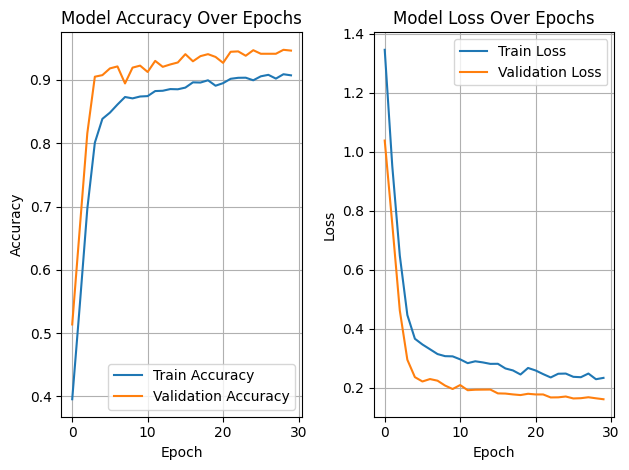

In [19]:
import matplotlib.pyplot as plt

# Plot training history
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Save model
model.save("deep_learning_model.keras")

In [21]:
example_low = {
    'price':                  100.00,
    'college':                'Arts;Architecture;Engineering',  # replace with one from your train set
    'Sub Category':           'Design',
    'rating':                 1.8,
    'stock':                  20,
    'is_out_of_stock':        0,
    'views_count':            50,
    'wishlist_count':         2,
    'add_to_cart_count':      1,
    'buyers_count':           0,
    'discount_pct':           0.02,
    'final_price':            4.90,
    'stock_range':            'high',
    'seasonality':            'spring',
    'effective_price':        4.80,
    'cart_to_view_ratio':     0.02,
    'wishlist_to_view_ratio': 0.04
}
example_df = pd.DataFrame([example_low])

# 3) Preprocess → predict
X_ex_processed = pipeline.transform(example_df)
probs          = model.predict(X_ex_processed)
pred_num       = np.argmax(probs, axis=1)
pred_label     = label_encoder.inverse_transform(pred_num)

print("Predicted price_range_category:", pred_label[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted price_range_category: Low


In [22]:
# 2) Define multiple examples in a list
examples = [
    {
        'price':                  5.00,
        'college':                'Arts;Architecture;Engineering',
        'Sub Category':           'Design',
        'rating':                 1.8,
        'stock':                  20,
        'is_out_of_stock':        0,
        'views_count':            50,
        'wishlist_count':         2,
        'add_to_cart_count':      1,
        'buyers_count':           0,
        'discount_pct':           0.02,
        'final_price':            4.90,
        'stock_range':            'low',
        'seasonality':            'spring',
        'effective_price':        4.80,
        'cart_to_view_ratio':     0.02,
        'wishlist_to_view_ratio': 0.04
    },
    {
        'price':                  199.99,
        'college':                'Engineering',
        'Sub Category':           'Mechanical',
        'rating':                 4.2,
        'stock':                  150,
        'is_out_of_stock':        0,
        'views_count':            500,
        'wishlist_count':        45,
        'add_to_cart_count':     30,
        'buyers_count':          5,
        'discount_pct':          0.15,
        'final_price':           169.99,
        'stock_range':           'medium',
        'seasonality':           'winter',
        'effective_price':       155.0,
        'cart_to_view_ratio':    0.06,
        'wishlist_to_view_ratio':0.09
    },
    {
        'price':                  59.50,
        'college':                'Arts;Architecture;Engineering',
        'Sub Category':           'Design',
        'rating':                 3.8,
        'stock':                  80,
        'is_out_of_stock':        0,
        'views_count':            1200,
        'wishlist_count':         150,
        'add_to_cart_count':      60,
        'buyers_count':           20,
        'discount_pct':           0.25,
        'final_price':            44.63,
        'stock_range':            'low',
        'seasonality':            'summer',
        'effective_price':        42.17,
        'cart_to_view_ratio':     0.05,
        'wishlist_to_view_ratio': 0.12
    }
]

# 3) Turn into a DataFrame
batch_df = pd.DataFrame(examples)

# 4) Preprocess & predict
X_batch_proc = pipeline.transform(batch_df)
probs_batch  = model.predict(X_batch_proc)
pred_nums    = np.argmax(probs_batch, axis=1)
pred_labels  = label_encoder.inverse_transform(pred_nums)

# 5) Attach predictions back to your DataFrame
batch_df['predicted_price_range'] = pred_labels

# 6) View results
print(batch_df[['predicted_price_range']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
  predicted_price_range
0                   Low
1                  High
2                   Low


In [23]:
for col in X.select_dtypes(include=['object']).columns:
    print(f"Column '{col}' unique values:")
    print(X[col].unique())
    print('-' * 40)

Column 'college' unique values:
['laboratory  tools' 'engineering' 'arts;architecture;engineering'
 'architecture;engineering - arts' 'plant anatomy'
 'faculty of bio technology' 'faculty of agriculture' 'arts'
 'faculty of dentistry' 'chemical tools' 'faculty of veterinary medicine'
 'architecture;engineering' 'animal dissection' 'faculty of nursing']
----------------------------------------
Column 'Sub Category' unique values:
['cleaning supplies' 'Rulers' 'Art Supplies' 'liquid handling'
 'chemical tools' 'Sculpture' 'microscopy supplies' 'Brushes' 'glassware'
 'Templates' 'Colors' 'Oils' 'Canvas' 'Drawing Sketch' 'safety equipment'
 'Pencils and Pens' 'cleaning tools' 'Art Boards and Bags'
 'dissection tools' 'storage equipment' 'Color Pallets']
----------------------------------------
Column 'stock_range' unique values:
['Medium' 'High' 'Low']
----------------------------------------
Column 'seasonality' unique values:
['Winter' 'Autumn' 'Spring' 'Summer']
------------------------